In [90]:
import json
from matplotlib import pyplot as plt
import microhapdb
import pandas as pd
from pathlib import Path

In [2]:
microhapdb.__version__

'0.11+8.gb390ac6.dirty'

In [ ]:
def aggregate_counts_and_averages():
    counts = pd.concat(map(sample_read_counts, ("SRM8398-1", "SRM8398-2", "SRM8398-3", "SRM8398-4")))
    counts = all_agg.sort_values(["Marker", "Sample"]).reset_index()
    averages = list()
    for markerid, subset in counts.groupby("Marker"):
        avg_type_rate = sum(subset.TypingRate) / len(subset.TypingRate)
        averages.append((markerid, avg_type_rate, subset.Length.iloc[0], subset.Ae.iloc[0]))
    averages = pd.DataFrame(averages, columns=["Marker", "TypingRate", "Length", "Ae"])
    averages["Locus"] = averages.Marker.apply(lambda x: x.split(".")[0]).sort_values("Ae", ascending=False).drop_duplicates("Locus", keep="first")
    return counts, averages

In [3]:
def sample_read_counts(sample_name):
    type_path = f"../scratch/WD_hybcap3_2023-11-07/analysis/{sample_name}/{sample_name}-type.json"
    repeat_path = f"../scratch/WD_hybcap3_2023-11-07/analysis/{sample_name}/{sample_name}-repetitive-reads.csv"
    table = parse_typed_read_counts(type_path)
    table = flag_repetitive_markers(table, repeat_path)
    table = incorporate_length_and_ae(table)
    table["Sample"] = sample_name
    return table[["Sample", "TotalReads", "TypedReads", "RepetitiveReads", "RepFlagged", "Length", "Ae"]].reset_index()

In [4]:
def parse_typed_read_counts(typing_counts_path):
    data = list()
    with open(typing_counts_path, "r") as fh:
        result = json.load(fh)
    for marker in result["markers"]:
        typed_reads = sum(result["markers"][marker]["typing_result"].values())
        untyped_reads = result["markers"][marker]["num_discarded_reads"]
        total_reads = typed_reads + untyped_reads
        data.append((marker, total_reads, typed_reads))
    return pd.DataFrame(data, columns=["Marker", "TotalReads", "TypedReads"]).set_index("Marker")

In [5]:
def flag_repetitive_markers(table, repeat_counts_path):
    data = pd.read_csv(repeat_counts_path)
    data["RepFlagged"] = data.Marker.apply(lambda x: x in microhapdb.repeats.index)
    data = data.set_index("Marker")
    return table.join(data, on="Marker")

In [6]:
def incorporate_length_and_ae(table):
    data = microhapdb.markers[["Name", "Extent", "Ae"]].copy().rename(columns={"Name": "Marker", "Extent": "Length"}).set_index("Marker")
    return table.join(data, on="Marker")

In [7]:
all_agg = pd.concat(map(aggregate_sample_data, ("SRM8398-1", "SRM8398-2", "SRM8398-3", "SRM8398-4")))
all_agg = all_agg.sort_values(["Marker", "Sample"]).reset_index()
all_agg

,index,Marker,Sample,TotalReads,TypedReads,RepetitiveReads,RepFlagged,Length,Ae
0,0,mh01CP-007,SRM8398-1,7058,6827,4562,True,17,1.330
1,0,mh01CP-007,SRM8398-2,8148,7880,5559,True,17,1.330
2,0,mh01CP-007,SRM8398-3,6066,5861,4038,True,17,1.330
3,0,mh01CP-007,SRM8398-4,8491,8186,5881,True,17,1.330
4,1,mh01CP-008,SRM8398-1,4120,3150,4120,True,17,2.697
...,...,...,...,...,...,...,...,...,...
2627,656,mh22USC-22qB.v2,SRM8398-4,6079,105,3,True,261,8.161
2628,657,mh22USC-22qB.v3,SRM8398-1,4927,410,1,True,251,8.337
2629,657,mh22USC-22qB.v3,SRM8398-2,5886,582,2,True,251,8.337
2630,657,mh22USC-22qB.v3,SRM8398-3,4167,399,1,True,251,8.337


In [44]:
all_agg = all_agg[~all_agg.RepFlagged]
all_agg["TypingRate"] = all_agg.apply(lambda row: row.TypedReads / row.TotalReads if row.TotalReads > 0 else 0.0, axis=1)

In [57]:
avg_agg = list()
for markerid, subset in all_agg.groupby("Marker"):
    avg_type_rate = sum(subset.TypingRate) / len(subset.TypingRate)
    avg_agg.append((markerid, avg_type_rate, subset.Length.iloc[0], subset.Ae.iloc[0]))
avg_agg = pd.DataFrame(avg_agg, columns=["Marker", "TypingRate", "Length", "Ae"])
avg_agg["Locus"] = avg_agg.Marker.apply(lambda x: x.split(".")[0])

(101, 5)
101


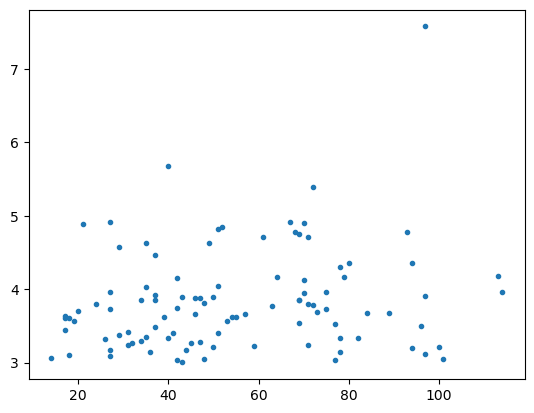

In [63]:
plot_data = avg_agg[(avg_agg.TypingRate > 0.5) & (avg_agg.Ae >= 3)].sort_values("Ae").drop_duplicates("Locus", keep="first")
#fig = plt.figure()
#ax = fig.add_subplot(111, projection="3d")
ax = plt.gca()
#ax.scatter(all_agg.TypingRate, all_agg.Ae, all_agg.Length, marker=".")
#ax.scatter(all_agg.TypingRate, all_agg.Length, marker=".")
ax.scatter(plot_data.Length, plot_data.Ae, marker=".")
#ax.set_xlabel("Typing Rate")
#ax.set_ylabel("$A_e$")
print(plot_data.shape)
print(len(plot_data.Locus.unique()))

(array([24., 36., 26., 25., 16., 11., 11., 11.,  6.,  7., 11., 13., 14.,
        20., 21., 25., 25., 33., 32., 14.]),
 array([0.00792507, 0.05752882, 0.10713256, 0.15673631, 0.20634006,
        0.2559438 , 0.30554755, 0.3551513 , 0.40475504, 0.45435879,
        0.50396253, 0.55356628, 0.60317003, 0.65277377, 0.70237752,
        0.75198127, 0.80158501, 0.85118876, 0.90079251, 0.95039625,
        1.        ]),
 <BarContainer object of 20 artists>)

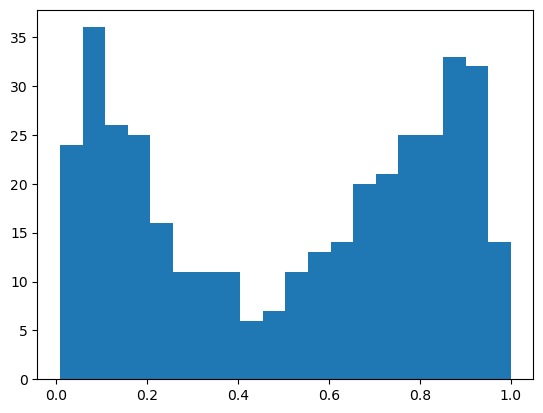

In [59]:
plt.hist(avg_agg.TypingRate, bins=20)

In [68]:
sorted(plot_data.Marker)

['mh01CP-012',
 'mh01KK-002',
 'mh01KK-211.v2',
 'mh01NH-04.v1',
 'mh01USC-1pA',
 'mh01USC-1pB',
 'mh01USC-1pD',
 'mh01USC-1qD',
 'mh02CP-004',
 'mh02KK-134.v4',
 'mh02KK-213',
 'mh02USC-2pA',
 'mh02USC-2pB',
 'mh02USC-2pC',
 'mh02USC-2qB.v1',
 'mh02USC-2qE',
 'mh03USC-3pA',
 'mh03USC-3pC',
 'mh03USC-3qA',
 'mh03USC-3qC.v1',
 'mh04CP-007',
 'mh04KK-010.v1',
 'mh04USC-4qB',
 'mh04USC-4qD',
 'mh05CP-004',
 'mh05CP-006',
 'mh05USC-5qA',
 'mh05USC-5qB',
 'mh05USC-5qD',
 'mh06CP-007',
 'mh06KK-030',
 'mh06USC-6pA',
 'mh06USC-6qA',
 'mh06USC-6qD',
 'mh07USC-7pB',
 'mh07USC-7pC',
 'mh07USC-7qA',
 'mh07USC-7qB',
 'mh08USC-8pA',
 'mh08USC-8pB',
 'mh08USC-8qA',
 'mh08USC-8qB',
 'mh09KK-033.v1',
 'mh09KK-153.v1',
 'mh09NH-13',
 'mh09USC-9pA.v1',
 'mh09USC-9pB',
 'mh09USC-9qB',
 'mh09USC-9qC',
 'mh0XUSC-XpA',
 'mh0XUSC-XpC',
 'mh0XUSC-XqG',
 'mh10CP-006',
 'mh11CP-005',
 'mh11KK-180.v4',
 'mh11NH-17',
 'mh11PK-62906',
 'mh11PK-63643.v2',
 'mh12CP-003',
 'mh12CP-007',
 'mh12KK-046.v1',
 'mh12KK-201

(318, 12)


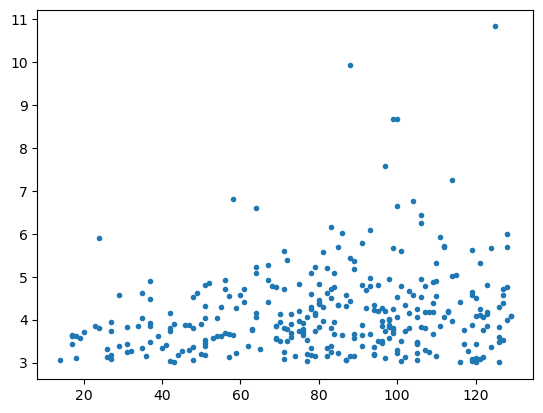

In [87]:
panel_ids = [
    m.name for m in microhapdb.Marker.objectify(microhapdb.markers) if
    (len(m) < 130) and (m.data.Ae > 3.0) and (m.name not in microhapdb.repeats.index)
]
panel_redund = microhapdb.markers[microhapdb.markers.Name.isin(panel_ids)].copy()
panel_redund["Locus"] = panel_redund.Name.apply(lambda x: x.split(".")[0])
panel = panel_redund.sort_values("Ae", ascending=False).drop_duplicates("Locus", keep="first")
plt.scatter(panel.Extent, panel.Ae, marker=".")
print(panel.shape)

In [88]:
print(sorted(panel.Name))

['mh01CP-012', 'mh01FHL-009.v2', 'mh01KK-001.v5', 'mh01KK-002', 'mh01KK-211.v2', 'mh01KK-212.v5', 'mh01LS-1pA', 'mh01NH-04.v1', 'mh01USC-1pA', 'mh01USC-1pB', 'mh01USC-1pD', 'mh01USC-1qD', 'mh01WL-008.v3', 'mh01WL-033.v1', 'mh01WL-037', 'mh01WL-038.v2', 'mh01WL-053.v1', 'mh01WL-058', 'mh01WL-059.v2', 'mh01WL-077.v2', 'mh01WL-087', 'mh01WL-110', 'mh01WL-115', 'mh01ZHA-012.v2', 'mh02CP-004', 'mh02KK-134.v2', 'mh02KK-213', 'mh02LS-2pB', 'mh02SHY-002.v2', 'mh02SHY-004.v1', 'mh02USC-2pA', 'mh02USC-2pB', 'mh02USC-2pC', 'mh02USC-2qB.v2', 'mh02USC-2qE', 'mh02WL-028.v2', 'mh02WL-050', 'mh02WL-054', 'mh02WL-060', 'mh02WL-079', 'mh02WL-084', 'mh02WL-090', 'mh02WL-097', 'mh02WL-099', 'mh02WL-100', 'mh02WL-105', 'mh02WL-108', 'mh02WL-112', 'mh02ZHA-012', 'mh03FHL-001.v1', 'mh03FHL-003.v2', 'mh03LS-3qD', 'mh03LS-3qE', 'mh03LS-3qF', 'mh03LV-06.v3', 'mh03SHY-005.v2', 'mh03USC-3pA', 'mh03USC-3pC', 'mh03USC-3qA', 'mh03USC-3qC.v1', 'mh03WL-005.v2', 'mh03WL-006.v4', 'mh03WL-010', 'mh03WL-011.v2', 'mh03WL-0

In [89]:
panel[panel.Ae > 9]

,Name,NumVars,Extent,Chrom,Start,End,Positions,Positions37,RSIDs,Source,Ae,Locus
2572,mh16WL-038,7,125,chr16,88727378,88727502,88727378;88727403;88727405;88727415;88727435;8...,88793786;88793811;88793813;88793823;88793843;8...,rs2242168;rs2340980;rs8057198;rs2879904;rs2242...,Yu2022G1,10.836,mh16WL-038
1687,mh10WL-012.v2,6,88,chr10,4259581,4259668,4259581;4259596;4259627;4259631;4259652;4259668,4301773;4301788;4301819;4301823;4301844;4301860,rs4880667;rs4880668;rs10904212;rs11252408;rs41...,Yu2022G4,9.940,mh10WL-012
